读取全部图片路径和标签 

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
def find_image_file(source_path, file_lst):
    """
    递归寻找 文件夹以及子目录的 图片文件。
    :param source_path: 源文件夹路径
    :param file_lst: 输出 文件路径列表
    :return:
    """
    image_ext = ['.jpg']
    for dir_or_file in os.listdir(source_path):
        file_path = os.path.join(source_path, dir_or_file)
        if os.path.isfile(file_path):  # 判断是否为文件
            file_name_ext = os.path.splitext(os.path.basename(file_path))  # 文件名与后缀
            if len(file_name_ext) < 2:
                continue
            if file_name_ext[1] in image_ext:  # 后缀在后缀列表中
                file_lst.append(file_path)
            else:
                continue
        elif os.path.isdir(file_path):  # 如果是个dir，则再次调用此函数，传入当前目录，递归处理。
            find_image_file(file_path, file_lst)
        else:
            print('文件夹没有环境' + os.path.basename(file_path))
env_path_list=[]
find_image_file('.\\ready_chinese_food',env_path_list)
label = [x.split('\\')[2] for x in env_path_list]
rawdata = pd.DataFrame([env_path_list,label],index=['path','label']).T
class_labels = rawdata.label.value_counts().index.tolist()
rawdata.label = rawdata.label.astype(int)
rawdata

,path,label
0,.\ready_chinese_food\1\1.jpg,1
1,.\ready_chinese_food\1\1086211.jpg,1
2,.\ready_chinese_food\1\10_0.jpg,1
3,.\ready_chinese_food\1\10_1.jpg,1
4,.\ready_chinese_food\1\10_13.jpg,1
...,...,...
110236,.\ready_chinese_food\99\maxresdefault.jpg,99
110237,.\ready_chinese_food\99\p800_201107022134050.jpg,99
110238,.\ready_chinese_food\99\p800_20120326201146676...,99
110239,.\ready_chinese_food\99\yaoguoxiqinchaoxiaren.jpg,99


In [7]:
rawdata.label.value_counts().sort_index()

1      1023
2       987
3       983
4       803
5       997
       ... 
168     352
169     462
170     379
171     347
172     879
Name: label, Length: 172, dtype: int64

定义数据加载器
标准化图片
划分训练测试集

In [8]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.values
        self.y = y.values
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img_path = self.X[idx]
        img = Image.open(img_path)
        img = img.resize((256, 256)) # 需要自定义图片size
        img = np.array(img,np.float32)/255.0
        return img.transpose((2, 0, 1)), self.y[idx]-1

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(rawdata['path'], rawdata['label'], test_size=0.2, random_state=42)

# Create DataLoader objects for the train and test sets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
batch_size = 200
train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

In [9]:
for xx,yy in train_loader:
    break

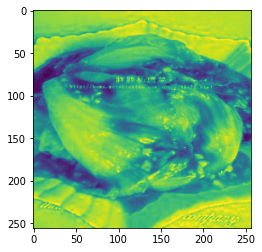

In [17]:
import matplotlib.pyplot as plt
plt.imshow(xx.numpy()[10][0]*255)

In [18]:
# 用例
for xx,yy in train_loader:
    print(xx.shape)
    print(yy.shape)
    break

torch.Size([200, 3, 256, 256])
torch.Size([200])


### Model

In [19]:
from mobilenetv2_fpn_od import MobileNetV2_dynamicFPN
model = MobileNetV2_dynamicFPN(num_classes = 172)
model

MobileNetV2_dynamicFPN(
  (first_layer): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
  )
  (inverted_residual_blocks): ModuleList(
    (0): Sequential(
      (0): InvertedResidual(
        (conv): Sequential(
          (0): ODConv2d(
            (attention): Attention(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu): ReLU(inplace=True)
              (channel_fc): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
              (filter_fc): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
              (kernel_fc): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
            )

In [21]:
output = model(torch.randn(3, 3, 224, 224))
print(output.shape)

torch.Size([3, 172])


### 定义加载函数

In [ ]:
model.load_state_dict(torch.load("path"))

3. Train the model.


In [9]:
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Define the model, loss function, and optimizer
model = model.to(device) # 定义网络参数
loss_fn = nn.CrossEntropyLoss() # 交叉熵损失函数|
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005) # 优化器
num_epochs = 20

def train_model(train_loader, test_loader, model, loss_fn, optimizer, num_epochs):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for i, (x, labels) in enumerate(train_loader):
            x, labels = x.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for x, labels in test_loader:
                x, labels = x.to(device), labels.to(device)
                outputs = model(x)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * x.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(test_loader.dataset)
        val_acc = val_correct / len(test_loader.dataset)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, model
train_loss_list, train_acc_list, val_loss_list, val_acc_list, model = train_model(train_loader, test_loader, model, loss_fn, optimizer, num_epochs)

cuda
Epoch [1/20], Train Loss: 1.3708, Train Acc: 0.3383, Val Loss: 1.3253, Val Acc: 0.4644
Epoch [2/20], Train Loss: 1.2701, Train Acc: 0.4878, Val Loss: 1.2309, Val Acc: 0.5593
Epoch [3/20], Train Loss: 1.1873, Train Acc: 0.5754, Val Loss: 1.1470, Val Acc: 0.5872
Epoch [4/20], Train Loss: 1.1114, Train Acc: 0.6208, Val Loss: 1.0682, Val Acc: 0.6276
Epoch [5/20], Train Loss: 1.0421, Train Acc: 0.6749, Val Loss: 1.0018, Val Acc: 0.6848
Epoch [6/20], Train Loss: 0.9789, Train Acc: 0.7434, Val Loss: 0.9379, Val Acc: 0.7950
Epoch [7/20], Train Loss: 0.9215, Train Acc: 0.7783, Val Loss: 0.8851, Val Acc: 0.7978
Epoch [8/20], Train Loss: 0.8720, Train Acc: 0.8265, Val Loss: 0.8318, Val Acc: 0.8759
Epoch [9/20], Train Loss: 0.8233, Train Acc: 0.8645, Val Loss: 0.7871, Val Acc: 0.8773
Epoch [10/20], Train Loss: 0.7811, Train Acc: 0.8471, Val Loss: 0.7460, Val Acc: 0.8773
Epoch [11/20], Train Loss: 0.7422, Train Acc: 0.8844, Val Loss: 0.7074, Val Acc: 0.9163
Epoch [12/20], Train Loss: 0.7064, T

4. Report the results.


In [10]:
class_labels = rawdata.label.value_counts().index.tolist()

In [11]:
#Step 4 implementation
from sklearn import metrics
true_list = []
pred_list = []
with torch.no_grad():
    for tests, labels in test_loader:
        tests, labels = tests.cuda().float(), labels.cuda().long()
        outputs = model(tests)  # 10,73->10,5
        true = labels.data
        predic = torch.max(outputs.data, 1)[1].cpu()
        true_list.extend(true)
        pred_list.extend(predic)
true = [int(x) for x in true_list]
predic = [int(x) for x in pred_list]
res=pd.DataFrame(metrics.classification_report(true,predic, digits=4,output_dict=True))
res

,teacher-up,student,teacher-down,ppt-only,accuracy,macro avg,weighted avg
precision,0.986607,0.882353,0.900826,1.000000,0.942817,0.942447,0.943096
recall,1.000000,0.942029,0.801471,0.986928,0.942817,0.932607,0.942817
f1-score,0.993258,0.911215,0.848249,0.993421,0.942817,0.936536,0.942102
support,221.000000,207.000000,136.000000,153.000000,0.942817,717.000000,717.000000


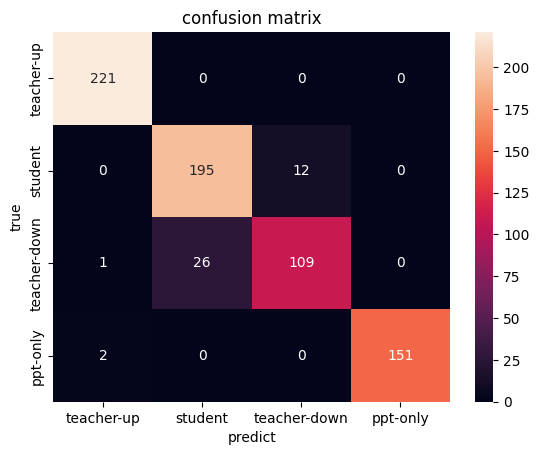

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
def plot_matrix(y_true, y_pred,title_name):
    cm = confusion_matrix(y_true, y_pred)#混淆矩阵
    #annot = True 格上显示数字 ，fmt：显示数字的格式控制
    ax = sn.heatmap(cm,annot=True,fmt='g')
    #xticklabels、yticklabels指定横纵轴标签
    ax.set_title(title_name) #标题
    ax.set_xlabel('predict') #x轴
    ax.set_ylabel('true') #y轴
    return ax
plot=plot_matrix(true,predic,'confusion matrix')
# plt.savefig('Confusion Matrix/CNN.png')
# 混淆矩阵

Save Model


In [13]:
torch.save(model,'./ckpt/classification.pth')

5. Test the model


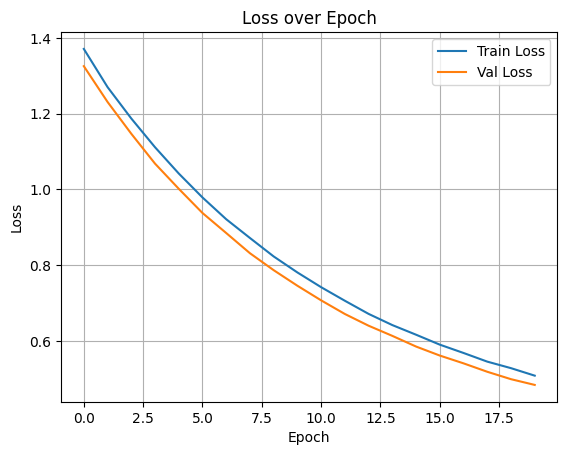

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss over Epoch')

# 显示图形
plt.show()


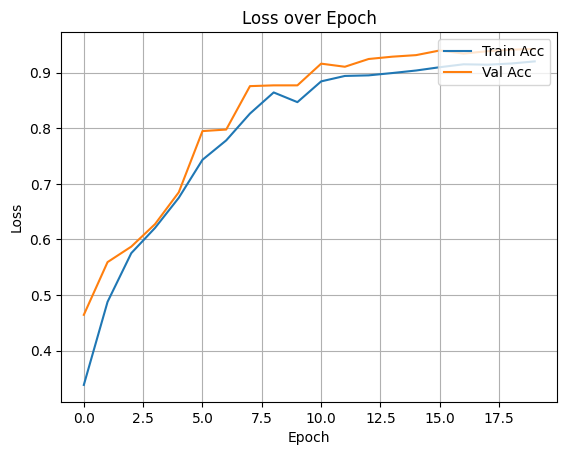

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('AcC over Epoch')

# 显示图形
plt.show()
